# Load

## Libs

In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    # source('../utils_mapping.R')
    source('../utils_plotting.R')
})


## Data

In [2]:
system.time({
    dname <- '../../data/cache/obj_fibroblasts/'
    fields_load <- c('meta_data', 'exprs_raw', 'masc_raw', 'masc')
    obj <- map(fields_load, function(name) {
        readRDS(file.path(dname, paste0(name, '.rds')))
    })
    names(obj) <- fields_load    
})


obj$masc_raw <- obj$masc_raw %>% 
    dplyr::left_join(unique(dplyr::select(obj$meta_data, Cluster, Cluster_name))) 

obj$masc <- obj$masc %>% 
    dplyr::left_join(unique(dplyr::select(obj$meta_data, Cluster, Cluster_name))) 


   user  system elapsed 
  8.671   0.988  10.435 

Joining, by = "Cluster"
Joining, by = "Cluster"


In [3]:
## for ligand-receptor analysis 
lr_df <- readRDS('../../data/cache/LR_analysis_full.rds')


In [4]:
lung <- readRDS('../../data/cache/lung_obj_all.rds')

# MASC raw vs beta 

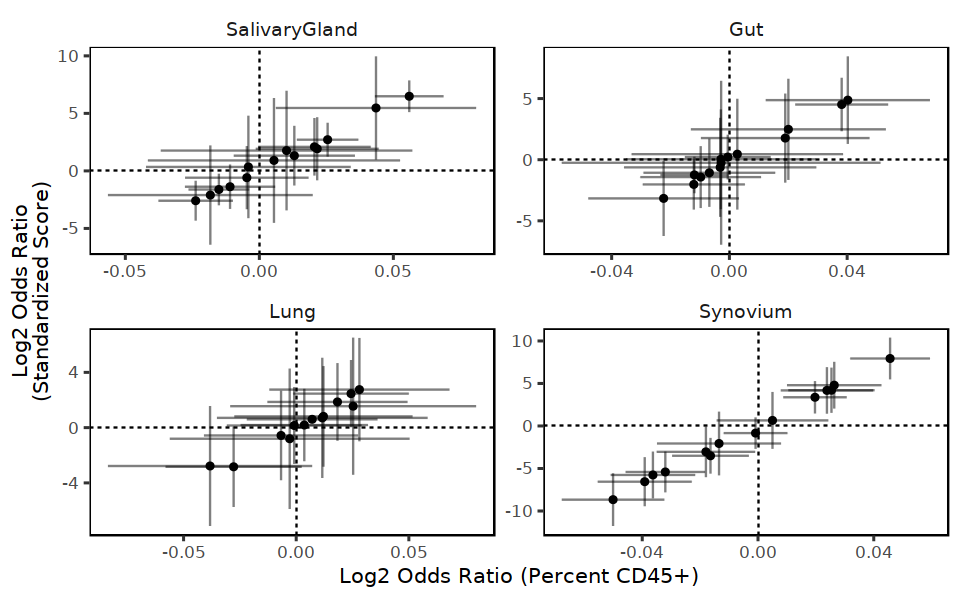

In [5]:
fig.size(5, 8)
p1 <- inner_join(obj$masc, obj$masc_raw, by = c('Cluster', 'Tissue'), suffix = c('_norm', '_raw')) %>% 
    subset(sigma_raw < 4 & sigma_norm < 4) %>% ## remove outliers
    ggplot(aes(beta_raw, beta_norm)) + 
        geom_point() + 
        facet_wrap(~Tissue, nrow = 2, scales = 'free') + 
        geom_vline(xintercept = 0, linetype = 2) +  
        geom_hline(yintercept = 0, linetype = 2) + 
#         geom_abline(linetype = 2) + 
        geom_errorbar(
            aes(ymin = beta_norm - 1.96 * sigma_norm, ymax = beta_norm + 1.96 * sigma_norm),
            alpha = .5
        ) + 
        geom_errorbarh(
            aes(xmin = beta_raw - 1.96 * sigma_raw, xmax = beta_raw + 1.96 * sigma_raw),
            alpha = .5
        ) + 
        labs(
            x = 'Log2 Odds Ratio (Percent CD45+)',
            y = 'Log2 Odds Ratio\n(Standardized Score)'
        ) + 
        NULL

p1


# Treatment status

In [6]:
.x <- readRDS('../../data/cache/obj_fibroblasts/meta_data.rds') %>% 
    dplyr::select(LibraryID, Tissue, Case, matches('^Inflam|^percent_cd45')) %>% 
    unique() %>% 
    inner_join(readRDS('../../data/clinical/treatment_r2c23.rds')) %>% 
    subset(!Case %in% c('GutControl', 'LungControl', 'GutNonisnflamed')) %>% 
    dplyr::mutate(Treatment = gsub('^ ', '', Treatment)) %>% 
    dplyr::mutate(Treatment = gsub(' .for Rheumatoid arthritis  systemic. ', '', Treatment)) %>% 
    dplyr::mutate(Treatment = gsub(' .anti integrina4b7.', '', Treatment)) %>% 
    dplyr::mutate(Treatment = gsub(' .immunosupressors. systemic ', '', Treatment)) %>% 
    dplyr::mutate(Tissue = case_when(
        Tissue == 'SalivaryGland' ~ 'Salivary\nGland',
        TRUE ~ Tissue
    )) %>% 
    identity()
#     dplyr::mutate(Treatment = stringr::str_wrap(Treatment, width = 60))

Joining, by = "LibraryID"


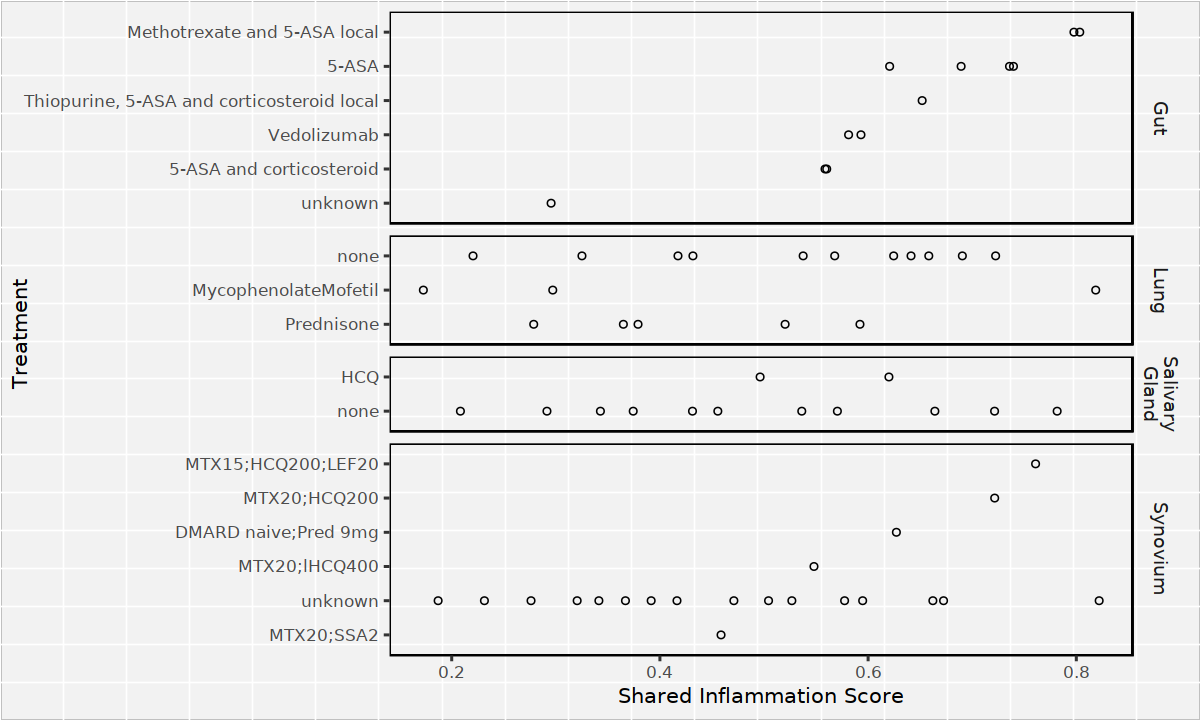

In [7]:
fig.size(6, 10)
p1b <- ggplot(.x, aes(reorder(Treatment, percent_cd45_beta3), percent_cd45_beta3)) + 
    geom_point(shape = 21, position = position_jitter(width = 0, height = 0.01)) + 
    coord_flip() + 
#     facet_wrap(~Tissue, scales = 'free_y', ncol = 1) + 
    facet_grid(Tissue~., scales = 'free', space = 'free') + 
    labs(x = 'Treatment', y = 'Shared Inflammation Score') + 
#     scale_color_manual(values = palette_global[unique(.x$Case)]) + 
#     scale_color_tableau() + 
    NULL    

p1b <- remove_strip_box(p1b)
plot(p1b)

# Lymphocyte inflammation score

In [8]:
scores_lymph <- readRDS('../../data/cache/lung_score_lymphocytes.rds')

scores_cd45 <- readRDS('../../data/cache/obj_fibroblasts/meta_data.rds') %>% 
    subset(Tissue == 'Lung') %>% 
    dplyr::select(LibraryID, percent_cd45) %>% unique() 

In [9]:
corres <- inner_join(scores_lymph, scores_cd45) %>% 
    with(cor.test(~percent_cd45 + percent_lymphocytes)) %>% 
    broom::tidy()
corres$p.value
corres$estimate

Joining, by = "LibraryID"


[1] 0.07329481

cor 
0.3804749

Joining, by = "LibraryID"
`geom_smooth()` using formula 'y ~ x'



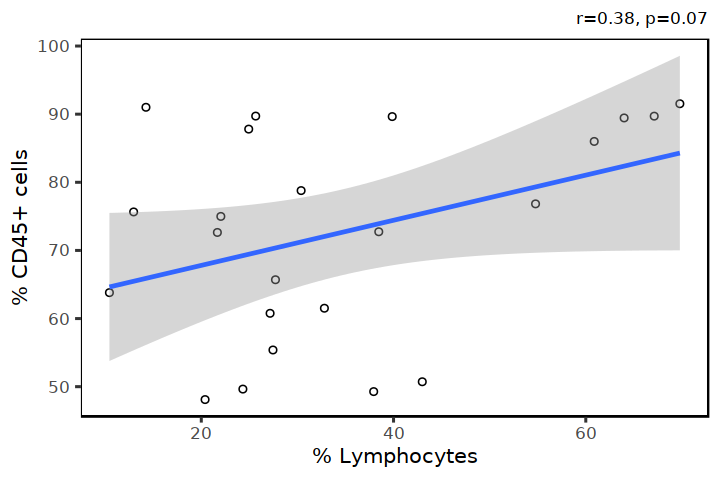

In [10]:
fig.size(4, 6)
p2 <- inner_join(scores_lymph, scores_cd45) %>% 
    ggplot(aes(percent_lymphocytes, percent_cd45)) + 
#     ggplot(aes(score_lymphocytes, percent_cd45_beta3)) + 
        geom_point(shape = 21) + 
        geom_smooth(method = 'lm') + 
        labs(x = '% Lymphocytes', y = '% CD45+ cells', title = 'r=0.38, p=0.07') + 
        theme(plot.title = element_text(size = 10, hjust=1)) + 
        NULL
p2

# Lymphocyte cluster markers 

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


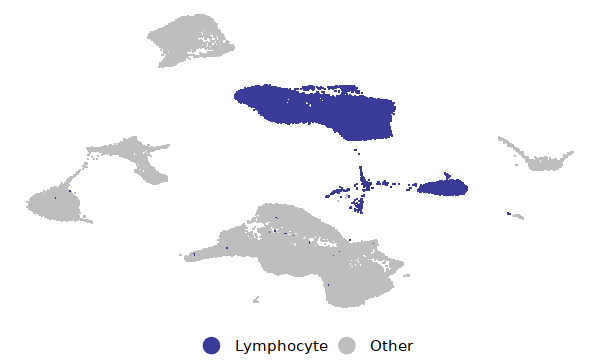

In [11]:
fig.size(3, 5)
p3 <- lung$umap_before %>% 
    data.table() %>% 
    cbind(lung$meta_data) %>% 
    dplyr::mutate(LABEL = case_when(
        lineage %in% c('t_nk', 'b_plasma') ~ 'Lymphocyte',
        TRUE ~ 'Other'
    )) %>% 
    ggplot(aes(V1, V2)) + 
        geom_point(shape = '.', aes(color = LABEL)) + 
        scale_color_manual(values = c(muted('blue'), 'grey')) + 
        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = FALSE) + 
        labs(x = 'UMAP 1', y = 'UMAP 2', color = '') + 
        theme_void() + 
        theme(legend.position = 'bottom') + 
        NULL
p3

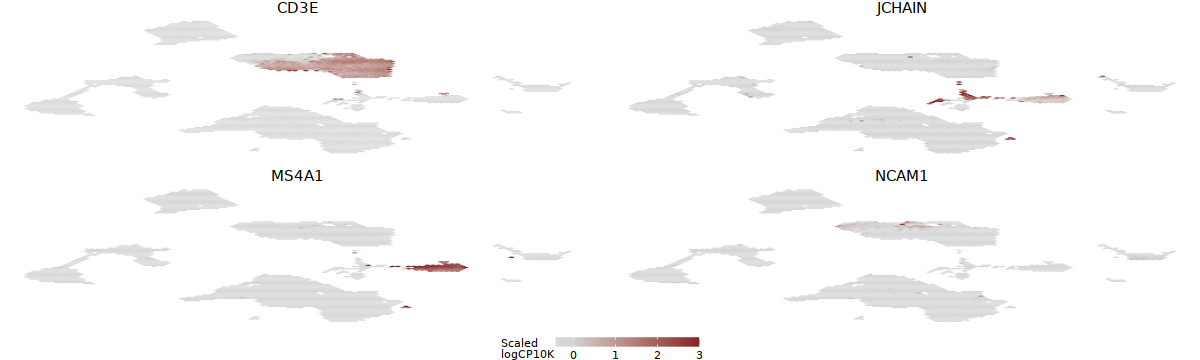

In [12]:
genes_plot <- c('MS4A1', 'CD3E', 'NCAM1', 'JCHAIN')

fig.size(3, 10)
# fig.size(8, 5)
p4 <- lung$umap_before %>% 
    data.table() %>% 
    cbind(lung$meta_data) %>% 
    cbind(t(scaleData(lung$exprs_norm[genes_plot, ], 1, 3))) %>% 
    tidyr::gather(gene, value, MS4A1:JCHAIN) %>% 
#     dplyr::mutate(value = pmin(value, 3)) %>% 
#     dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))) %>% 
    ggplot(aes(V1, V2, z = value)) + 
        stat_summary_hex(bins = 100) + 
        facet_wrap(~gene, nrow = 2) + 
#         facet_grid(Tissue ~ gene) + 
#         facet_grid(gene ~ Tissue) + 
#         scale_fill_gradient2_tableau() + 
        scale_fill_gradient2(mid = 'lightgrey', low = 'white', high = muted('red'), midpoint = 0) + 
        labs(x = 'UMAP 1', y = 'UMAP 2', fill = 'Scaled\nlogCP10K') + 
#         guides(fill = FALSE) + 
        theme_void() + 
        theme(
            legend.title = element_text(size = 6), 
            legend.text = element_text(size = 6),
            legend.key.height = unit(.2, 'cm'), 
#             legend.key.width = unit(.2, 'cm'), 
            legend.position = 'bottom'
        ) + 
        scale_x_continuous(breaks = c(-5, 0, 5)) + 
        scale_y_continuous(breaks = c(-5, 0, 5)) + 
#         guides(fill = guide_legend(override.aes = list(size = 0.5))) + 
        NULL

p4

# CD45 vs lymphocyte MASC 

In [13]:
masc_res_lymph <- readRDS('../../data/cache/masc_lung_lymphocytes.rds')

plt_df <- readRDS('../../data/cache/obj_fibroblasts/masc.rds') %>%
    subset(Tissue == 'Lung') %>% 
    arrange(-beta) %>% 
    left_join(masc_res_lymph, by = c('Cluster'), suffix = c('_cd45', '_lymph')) 


cor.test(~beta_cd45 + beta_lymph, plt_df)


	Pearson's product-moment correlation

data:  beta_cd45 and beta_lymph
t = 2.9424, df = 12, p-value = 0.01232
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1779136 0.8767937
sample estimates:
     cor 
0.647382 


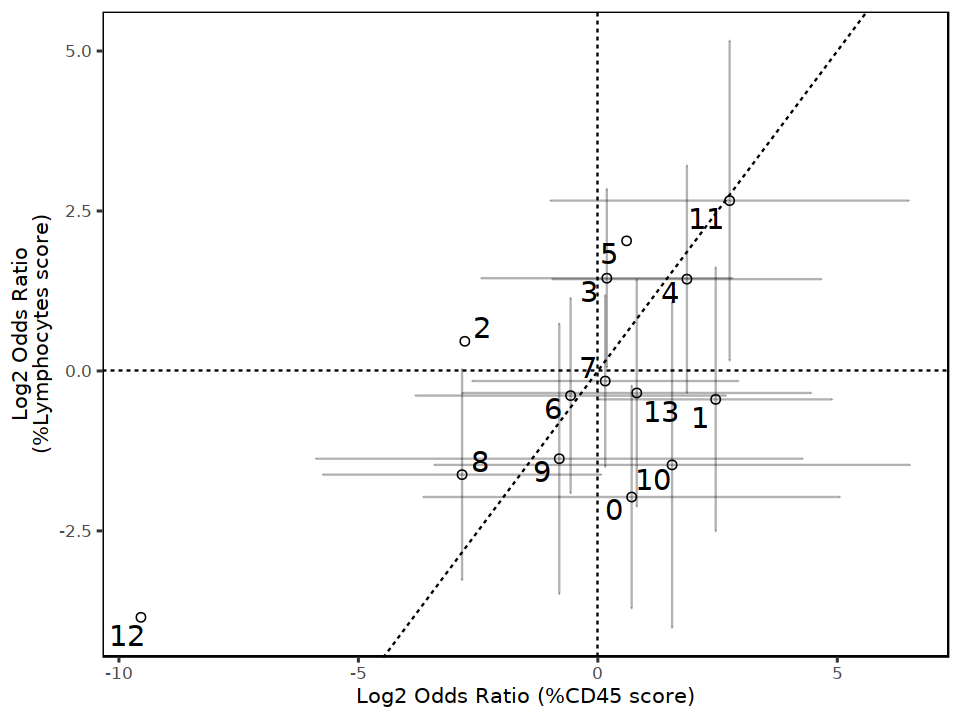

In [14]:
fig.size(6, 8)
p5 <- ggplot(plt_df, aes(beta_cd45, beta_lymph)) + 
    geom_hline(yintercept = 0, linetype = 2) + 
    geom_vline(xintercept = 0, linetype = 2) + 
    geom_abline(linetype = 2) + 
    geom_point(shape = 21, size = 2) + 
    geom_errorbarh(
        data = subset(plt_df, (sigma_cd45 < 3 & sigma_lymph < 3) & (sigma_cd45 > .05 & sigma_lymph > .05)),
        aes(xmin = beta_cd45 -1.96 * sigma_cd45, xmax = beta_cd45 + 1.96 * sigma_cd45), 
        alpha = .3
    ) + 
    geom_errorbar(
        data = subset(plt_df, (sigma_cd45 < 3 & sigma_lymph < 3) & (sigma_cd45 > .05 & sigma_lymph > .05)),        
        aes(ymin = beta_lymph -1.96 * sigma_lymph, ymax = beta_lymph + 1.96 * sigma_lymph), 
        alpha = .3
    ) + 
    geom_text_repel(aes(label = Cluster), size = 6) + 
    labs(x = 'Log2 Odds Ratio (%CD45 score)', y = 'Log2 Odds Ratio\n(%Lymphocytes score)') + 
#     theme() + 
    NULL 

p5

# Viper TF enrichment

In [16]:
tf_activities <- readRDS('../../data/cache/viper_res.rds') 

tfs_top <- tf_activities %>% 
#     subset(confidence %in% c('A', 'B', 'C')) %>% 
    subset(Cluster %in% c('4', '11')) %>% 
    split(.$Cluster) %>% 
    map(arrange, -score) %>% 
    map(head, 10) %>% 
    bind_rows()


In [17]:
# tfs_top %>% 
#     split(.$Cluster)

In [18]:
X <- tf_activities %>% 
#     subset(Cluster_name %in% c('CXCL10+CCL19+ C11', 'SPARC+COL3A1+ C4')) %>% 
    subset(feature %in% tfs_top$feature) %>% 
    dplyr::select(Cluster_name, score, feature) %>% 
    tidyr::spread(Cluster_name, score) %>% tibble::column_to_rownames('feature') %>% as('matrix') %>% 
    t %>% scale %>% t ## Scales the TFs
#     identity()

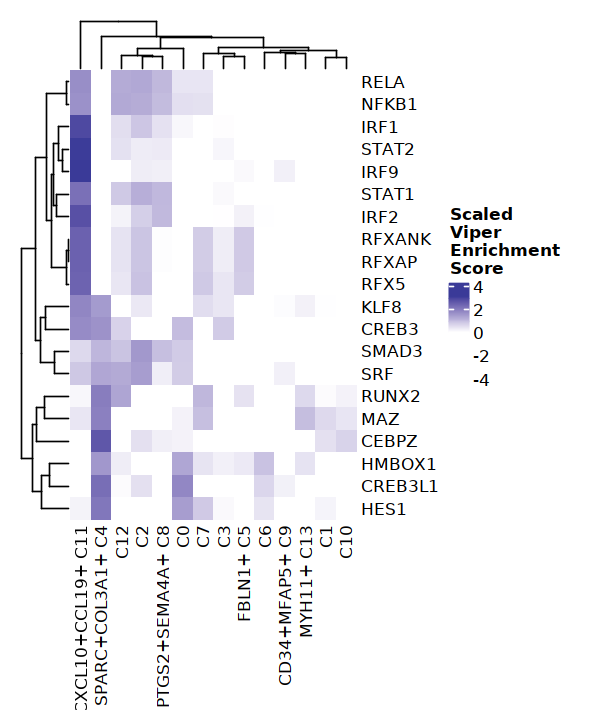

In [19]:
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))

p6 <- Heatmap(
    X,
    colorRamp2(c(-max(X), 0, max(X)), c('white', 'white', muted('blue'))),      
    name = 'Scaled\nViper\nEnrichment\nScore'
)

p6 <- grid.grabExpr(draw(p6, padding = unit(c(2, 2, 2, 10), "mm"), heatmap_legend_side = 'right')) #bottom, left, top, right paddings


fig.size(6, 5)
wrap_elements(p6)

# Ligand-Receptor

In [20]:
plt_df <- lr_df %>% 
    subset(pvalue_ec < 0.05 & pvalue_fib < 0.05 & beta_ec > 0 & beta_fib > 0) %>% 
    dplyr::mutate(SCORE = .5 * (zscore_ec + zscore_fib)) %>% 
    dplyr::left_join(unique(dplyr::select(obj$meta_data, Cluster, Cluster_name))) %>% 
    arrange(Cluster, -SCORE)


cluster_levels <- data.table(plt_df)[, .N, by = .(Cluster, Cluster_name)][order(-N), Cluster] 
cluster_levels <- paste0('C', cluster_levels)
# cluster_levels <- data.table(plt_df)[, .N, by = .(Cluster, Cluster_name)][order(-N), Cluster_name]
plt_df <- plt_df %>% 
    dplyr::mutate(pathway = glue('{ligand}:{receptor}')) %>% 
    dplyr::mutate(Cluster = factor(paste0('C', Cluster), cluster_levels)) 
#     dplyr::mutate(Cluster_name = factor(Cluster_name, cluster_levels)) 
#     dplyr::mutate(Cluster = factor(Cluster, cluster_levels)) 


# head(plt_df)

Joining, by = "Cluster"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


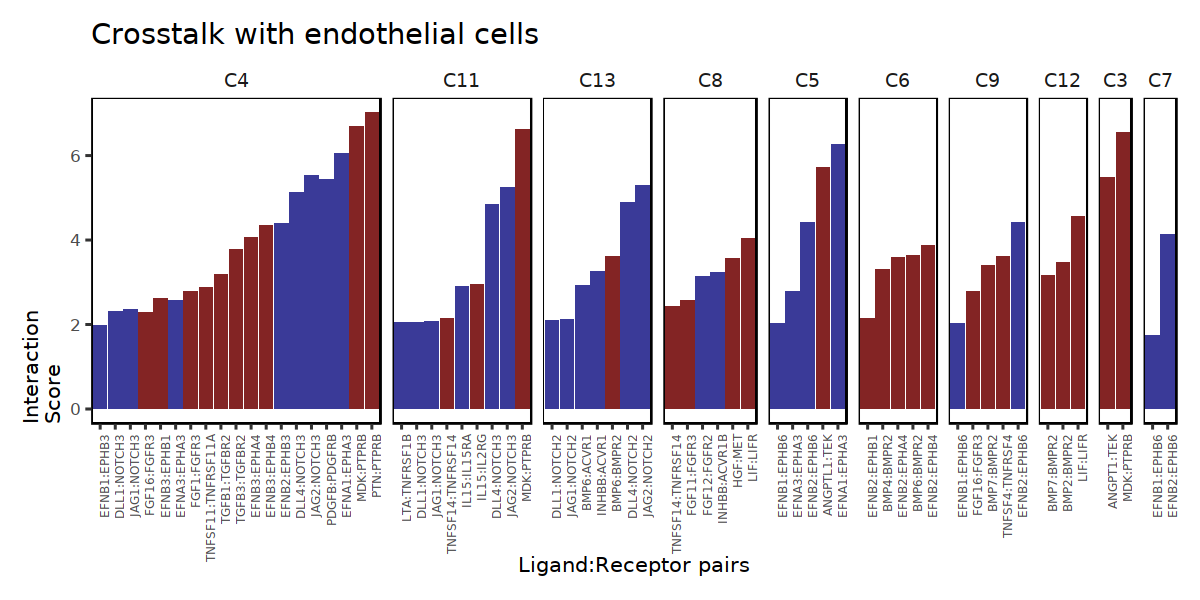

In [21]:
fig.size(5, 10)
p7 <- plt_df %>% 
#     dplyr::mutate(Cluster_name = gsub(' ', '\n', Cluster_name)) %>% 
    ggplot(aes(reorder(pathway, SCORE), SCORE, fill = type)) + 
#     ggplot(aes(reorder(pathway, SCORE), SCORE, fill = Cluster)) + 
        geom_bar(stat = 'identity') + 
#         coord_flip() + 
        facet_grid(. ~ Cluster, scales = 'free', space = 'free') + 
        scale_fill_manual(values = c(muted('blue'), muted('red'))) + 
        labs(
            x = 'Ligand:Receptor pairs', 
            y = 'Interaction\nScore', 
            title = 'Crosstalk with endothelial cells'
        ) + 
        theme(
            legend.position = 'bottom',
            strip.text.y = element_text(angle = 0, hjust = 0),
            axis.title.y = element_text(hjust = 0),
            axis.text.x = element_text(angle = 90, hjust = 1, size = 7),
        ) + 
        guides(fill = FALSE) + 
        NULL

p7 <- remove_strip_box(p7)
wrap_elements(p7)

# Inflammation association within clusters 

In [22]:
res_dds <- readRDS('../../data/cache/R2C07_deseq2.rds')

In [23]:
# fig.size(3, 12)
# # genes_plot <- c('CXCL10', 'CCL19', 'CXCL13')
# .x <- res_dds %>% 
# #     subset(Cluster %in% c('11')) %>% 
#     inner_join(effects_nested, by = c('Tissue', 'Cluster', 'feature'), suffix = c('_inflam', '_marker')) %>% 
#     arrange(feature %in% genes_plot) 

In [24]:
df_numbers <- res_dds %>% 
#     subset(padj < .05 & log2FoldChange >= 1) %>% 
    subset(pvalue < .05 & log2FoldChange >= 1) %>% 
    split(paste(.$Tissue, .$Cluster)) %>% 
    map(nrow) %>% 
    bind_rows() %>% t() %>% 
    data.frame() %>% 
    tibble::rownames_to_column('X') %>% 
    tidyr::separate(X, c('Tissue', 'Cluster')) %>% 
    dplyr::rename(n_dge = '.') %>% 
    left_join(data.table(obj$meta_data)[, .(n_cells = .N), by = .(Cluster, Tissue)]) %>% 
    left_join(unique(dplyr::select(obj$meta_data, matches('^Cluster'))))
head(df_numbers)

Joining, by = c("Tissue", "Cluster")
Joining, by = "Cluster"


,Tissue,Cluster,n_dge,n_cells,Cluster_name
,<chr>,<chr>,<int>,<int>,<chr>
1,Gut,0,553,349,C0
2,Gut,1,769,2653,C1
3,Gut,10,168,1203,C10
4,Gut,11,264,541,CXCL10+CCL19+ C11
5,Gut,12,1784,1057,C12
6,Gut,13,131,344,MYH11+ C13


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
`geom_smooth()` using formula 'y ~ x'



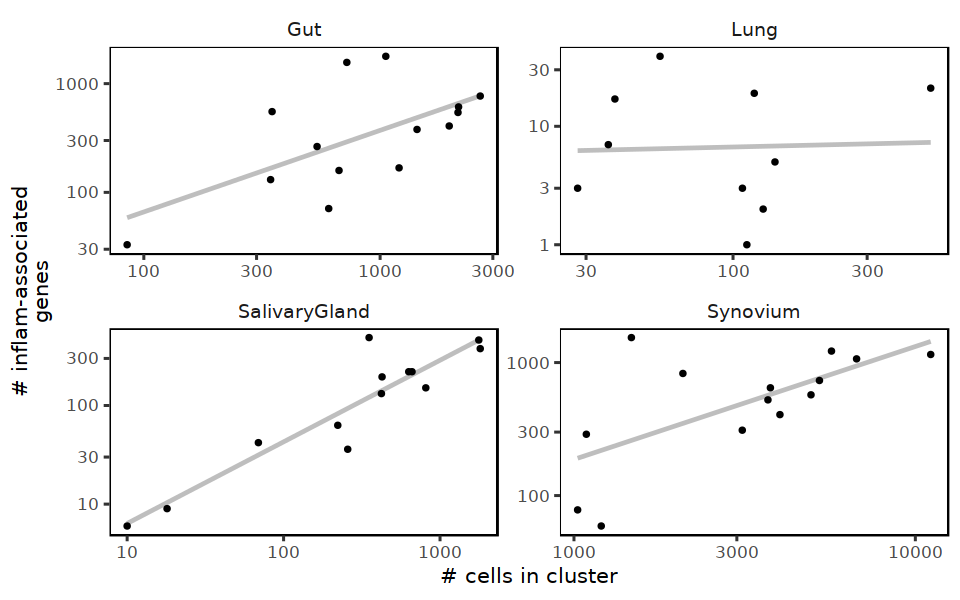

In [25]:
fig.size(5, 8)
p8 <- df_numbers %>% 
    ggplot(aes(n_cells, n_dge)) + 
        geom_smooth(method = 'lm', se = FALSE, color = 'grey') + 
        geom_point(shape = 16) + 
#         geom_text_repel(
#             aes(label = Cluster), min.segment.length = .1
#         ) + 
        facet_wrap(~Tissue, scales = 'free', nrow = 2) + 
        scale_x_log10() +
        scale_y_log10() + 
        labs(x = '# cells in cluster', y = '# inflam-associated\ngenes') + 
#         labs(x = '# cells', y = '# genes', title = 'Inflammation-associated genes') + 
        scale_color_manual(values = c('black', muted('red'))) + 
        guides(color = FALSE) + 
        NULL

p8

# Panels

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


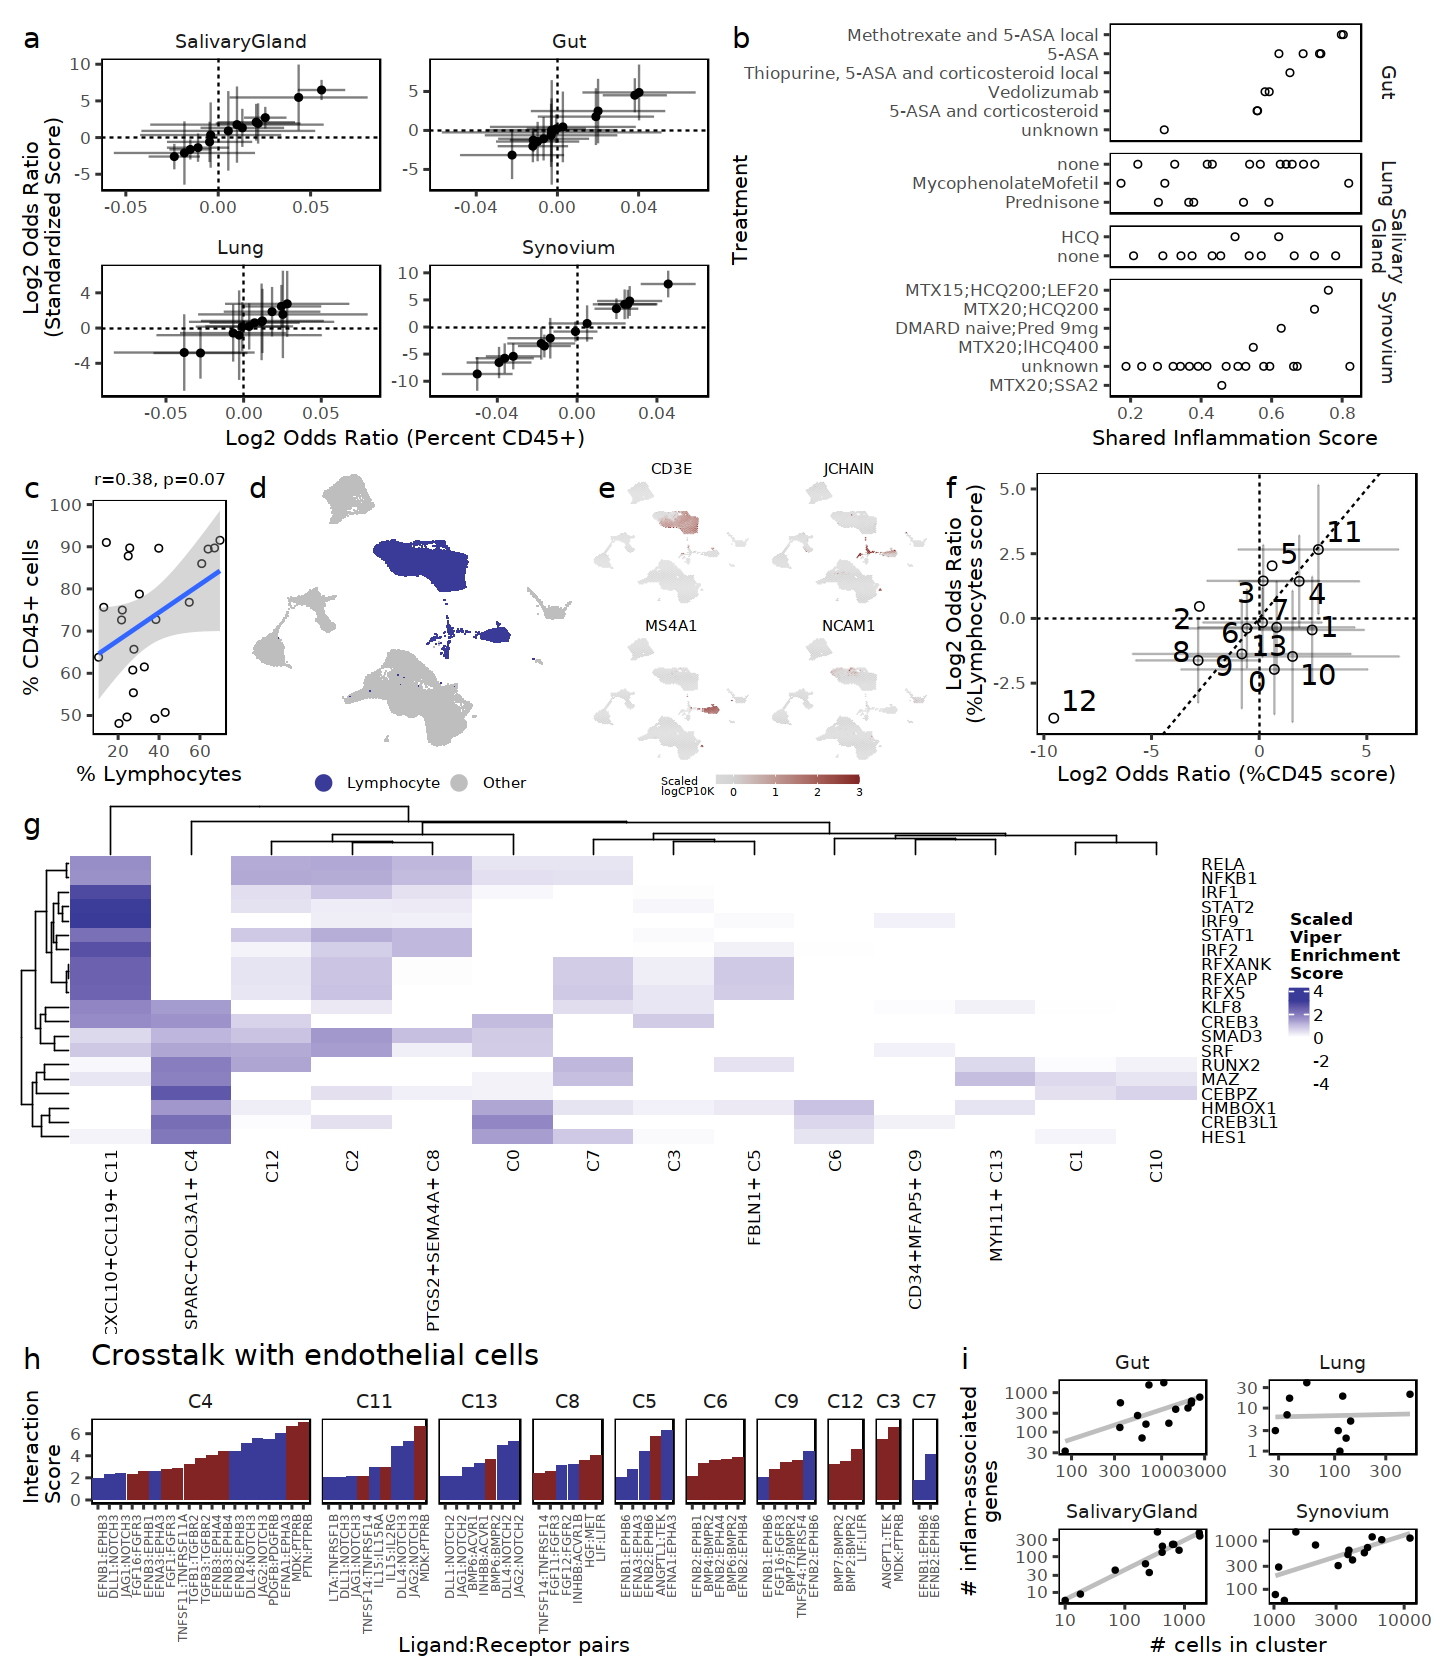

In [26]:
fig.size(14, 12)
(
    (
        (wrap_elements(full = p1) | wrap_elements(full = p1b)) + plot_layout(widths = c(1, 1))    
    ) / 
    (
        (wrap_elements(full = p2) | wrap_elements(full = p3) | wrap_elements(full = p4) | wrap_elements(full = p5)) + plot_layout(widths = c(.6, 1, 1, 1.5))    
    ) / 
  
    (
        wrap_elements(full = p6)    
    ) / 
#     (
#         (wrap_elements(full = p1) | wrap_elements(full = p2)) + plot_layout(widths = c(1, 1.5))
#     ) / 
    (
        (wrap_elements(full = p7) | wrap_elements(full = p8)) + plot_layout(widths = c(2, 1))
    )
) + 
plot_layout(heights = c(1.4, 1, 1.7, 1)) + 
plot_annotation(tag_levels = 'a')



In [27]:
ggsave(
    filename = '../../manuscript/figures/SuppFigure5.pdf', 
    units = 'in', device = 'pdf', 
    height = 14, width = 12,
    useDingbats = FALSE
)


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

